<a href="https://colab.research.google.com/github/roy029/mpT5/blob/main/create_mt5_enjapy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers sentencepiece

このノートブックの目的は、mT5モデルの多言語版から英語版、日本語版を作成することです。
Pythonコードを扱うNLPタスクに対してmT5を使うことも考えていきたい。

# Removing the unused vocabulary

In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [3]:
tokenizer = T5Tokenizer.from_pretrained("google/mt5-base")
tokenizer

PreTrainedTokenizer(name_or_path='google/mt5-base', vocab_size=250100, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [4]:
model = T5ForConditionalGeneration.from_pretrained('google/mt5-base')

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Our tokenizer contains 250K tokens, 

In [5]:
print(tokenizer.vocab_size)

250100


The model has 582M parameters. 

In [6]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

582401280
192086016
encoder
277040256
84953472
decoder
305361024
113274240
192086016


Input and output embeddings are 66% of the whole model

In [7]:
print(msize(model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))

0.32981729710484153
0.32981729710484153


# Determine the new tokens

Take a file from https://wortschatz.uni-leipzig.de/en/download/Russian as a representation of Russian language. It contains 1M sentences. 

Also take a similar representation of English, because we want our model to be bilingual, and English shares few tokens with Russian.

ロシア語と同様にして1M行を含む日本語辞書を用意する。

In [8]:
# 日本語
!wget http://pcai056.informatik.uni-leipzig.de/downloads/corpora/jpn_wikipedia_2021_1M.tar.gz
!tar -xsvf jpn_wikipedia_2021_1M.tar.gz

--2022-04-06 06:12:45--  http://pcai056.informatik.uni-leipzig.de/downloads/corpora/jpn_wikipedia_2021_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252537981 (241M) [application/x-gzip]
Saving to: ‘jpn_wikipedia_2021_1M.tar.gz.1’

jpn_wikipedia_2021_ 100%[===================>] 240.84M  10.8MB/s    in 24s     

2022-04-06 06:13:11 (9.86 MB/s) - ‘jpn_wikipedia_2021_1M.tar.gz.1’ saved [252537981/252537981]

jpn_wikipedia_2021_1M/
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-import.sql
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-sources.txt
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-inv_so.txt
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-inv_w.txt
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-co_s.txt
jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-sentences.txt
jpn_wik

In [9]:
# 英語
!wget http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
!tar -xsvf eng-com_web-public_2018_1M.tar.gz

--2022-04-06 06:13:19--  http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228887647 (218M) [application/x-gzip]
Saving to: ‘eng-com_web-public_2018_1M.tar.gz.2’

eng-com_web-public_ 100%[===================>] 218.28M  10.8MB/s    in 22s     

2022-04-06 06:13:42 (9.79 MB/s) - ‘eng-com_web-public_2018_1M.tar.gz.2’ saved [228887647/228887647]

eng-com_web-public_2018_1M/
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-co_s.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-inv_so.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-words.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sentences.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sour

In [10]:
#conalaコード
!git clone https://github.com/y-akinobu/corpus_Python-JPN.git

fatal: destination path 'corpus_Python-JPN' already exists and is not an empty directory.


Let us look at the sentences

In [11]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
fname = '/content/jpn_wikipedia_2021_1M/jpn_wikipedia_2021_1M-sentences.txt'
df_ja = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_ja.columns = ['idx', 'text']
df_ja.sample(5)

,idx,text
308226,308227,』に収録されている水瀬伊織の「フタリの記憶」の再生回数は2000回を超えている。
79438,79439,このようなillの確認応答によって、それまでに送信した全てのパケットが正しく受信されたことが保証される。
475582,475583,引退後は、2012年に自身の体操クラブである米田功体操クラブを設立、2013年1月からは徳洲会体操クラブの監督となる 。
982170,982171,サマルカンドからの風景（1900年以前）
744245,744246,町の北と南はいずれも高い山が続き、


In [62]:
fname = 'eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sentences.txt'
df_en = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
295614,295615,I added 2/3 cups of sugar instead of 1/3cup to your recipe.
743009,743010,The hard part is what it may do to my cruelty to myself.
559725,559726,"Odds are good that visitors to the site from March 2016 through early this month were compromised, with their credit card data flowing to a Russian language Internet service provider in Belize."
432906,432907,"It ran in our family, so to speak."
88942,88943,"A tiny client runs on your machine and automatically keeps your important files backed up to Carbonite’s remote servers, which provide an unlimited amount of storage."


In [53]:
fname = '/content/corpus_Python-JPN/Corpus-conala/conala_orig.tsv'
df_py = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_py.columns = ['text', 'trans']
df_py = df_py.rename_axis('idx').reset_index()
df_py = df_py[['idx', 'text']]
df_py.sample(5)

,idx,text
1968,1968,"dict ( ( k , v * dict2 [ k ] ) for k , v in list ( dict1 . items ( ) ) if k in dict2 )"
1651,1651,"df = df . drop ( 'column_name' , 1 )"
1503,1503,"canvas . create_text ( x , y , font = ( 'Purisa' , 12 ) , text = k )"
1914,1914,"x [ ( np . arange ( x . shape [ 0 ] ) != 1 ) , : , : ]"
667,667,"url ( '^$' , TemplateView . as_view ( template_name = 'your_template.html' ) )"


Count the tokens that the current model uses for representing the sentences. 

In [59]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_ja = Counter()
for text in tqdm(df_ja.text):
    cnt_ja.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [63]:
cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
cnt_py = Counter()
for text in tqdm(df_py.text):
    cnt_py.update(tokenizer.encode(text))

The tokens that are ever used with Russian are 23% of the whole vocabulary. With English, it is 27%.

Surprisingly, there is more than 50% overlap between the vocabularies. Perhaps, this is because in Russian texts there are occasionally English words or other words with latin alphabet. 

In [57]:
print(len(cnt_ja), len(cnt_ja)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
print(len(cnt_py), len(cnt_py)/tokenizer.vocab_size)
common = len(set(cnt_ja.keys()).intersection(set(cnt_en.keys()))) #日本語
commonn = len(set(cnt_py.keys()).intersection(set(cnt_en.keys()))) #Pythonコード
print(common, common / len(cnt_ja))
print(commonn, commonn / len(cnt_py))

80189 0.3206277489004398
1640 0.006557377049180328


NameError: ignored

For both English and Russian, 10K tokens cover about 95% of the vocabulary, and 20K - about 99%. 

In [16]:
print('ja')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_ja.most_common(top)) / sum(cnt_ja.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))

ja
10000 0.952994509489272
20000 0.9886598605517815
30000 0.9945652171784659
en
10000 0.9531899764307693
20000 0.9840809828270257
30000 0.9937869259525808


Remember the old vocabulary, because we are going to replace it soon!

In [17]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [18]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_ja.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))

['▁', '、', '</s>', '。', 'の', 'は', 'が', 'を', 'に', 'と', '・', ')', '(', 'で', '」', '「', 'した', '年', 'する', 'し', 'から', 'も', '』', 'や', 'である', 'された', 'として', '月', 'では', '▁archive']
['▁', '</s>', '.', '▁the', ',', 's', '▁to', '▁and', 'a', '▁of', '▁in', '▁is', '▁I', '’', '▁that', 'ed', '▁for', '-', 'ing', "'", '▁you', '▁it', '▁with', '▁on', 'ly', 'y', '▁be', '▁The', '▁as', '▁are']


We try the following composition of vocabulary:
* 1K of top tokens of the original tokenizer (just in case)
* Top 10K of the English vocabulary
* Top 20K of the Russian vocabulary (or more, to make the total number of tokens 30K)
* 100 special tokens that T5 uses


In [19]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_ja.most_common(25_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Japanese tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

21432 Japanese tokens are included
30000


The new vocabulary is only 12% of the original one. 

In [20]:
len(kept_ids) / tokenizer.vocab_size

0.11995201919232307

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward). 

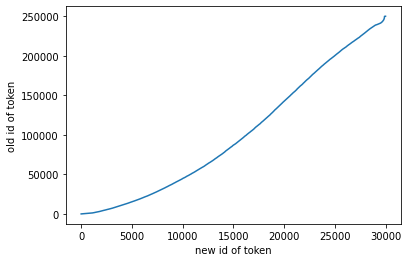

In [21]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [22]:
import torch

In [23]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [24]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [25]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

The new model has 244M parameters - 42% of the original size. 

In [26]:
print(msize(model), msize(model) / original_size)

244309248 0.4194861110195362


### Update the tokenizer

T5 uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python. 

Fortunately, we can download its model and deploy it into Python using its Protobuf representation. 

https://github.com/google/sentencepiece/issues/121

In [27]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2022-04-06 06:24:37--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12872 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto.1’

sentencepiece_model 100%[===================>]  12.57K  --.-KB/s    in 0.001s  

2022-04-06 06:24:37 (16.1 MB/s) - ‘sentencepiece_model.proto.1’ saved [12872/12872]



We compile the protobuf description of the sentencepiece model in order to be able to modify it. 

In [28]:
! protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class. 

In [29]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 30000


  0%|          | 0/220100 [00:00<?, ?it/s]

30000


In [30]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

### Save the model

In [31]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'cointegrated/rut5-base'
model.config

T5Config {
  "_name_or_path": "cointegrated/rut5-base",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.17.0",
  "use_cache": true,
  "vocab_size": 30000
}

In [32]:
new_tokenizer.save_pretrained('rut5-base')
model.save_pretrained('rut5-base')

In [33]:
!ls rut5-base -alsh

total 933M
4.0K drwxr-xr-x 2 root root 4.0K Apr  6 04:04 .
4.0K drwxr-xr-x 1 root root 4.0K Apr  6 06:24 ..
4.0K -rw-r--r-- 1 root root  706 Apr  6 06:25 config.json
933M -rw-r--r-- 1 root root 933M Apr  6 06:25 pytorch_model.bin
4.0K -rw-r--r-- 1 root root   65 Apr  6 06:25 special_tokens_map.json
756K -rw-r--r-- 1 root root 755K Apr  6 06:25 spiece.model
4.0K -rw-r--r-- 1 root root  173 Apr  6 06:25 tokenizer_config.json


Now try to load the model

In [34]:
model1 = T5ForConditionalGeneration.from_pretrained('rut5-base')
tokenizer1 = T5Tokenizer.from_pretrained('rut5-base')

The model has not been fine-tuned on any sensible task except filling the gaps. And even this task is performed strangely - the models continues generating when it should have stopped. 

But we hope that after fine-tuning it will be better. But this is the topic of the next story)

In [35]:
inputs = tokenizer1('The <extra_id_0> walks in <extra_id_1> park.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> local <extra_id_1> the <extra_id_2> a beautiful <extra_id_3> international <extra_id_4> national <extra_id_5> bottom!</s>
<pad> <extra_id_0> annual <extra_id_1> the <extra_id_2> her car.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> trees <extra_id_1> the <extra_id_2> the <extra_id_3> trees <extra_id_4> the lake.</s> <pad> <pad>


In [36]:
inputs = tokenizer1('Красивая <extra_id_0> гуляет <extra_id_1> парку.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> куу- <extra_id_1>а <extra_id_2>! <extra_id_3>рм.</s> <pad> <pad>
<pad> <extra_id_0>: <extra_id_1>- <extra_id_2>. ои <extra_id_3>. 5 хр</s>
<pad> <extra_id_0> н <extra_id_1>д. <extra_id_2>у <extra_id_3>. Апае</s> <pad>


I will save the model on my Google drive to retrieve it later for fine-tuning. 

In [37]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [38]:
model1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')
tokenizer1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')

('/gd/MyDrive/models/rut5-base-raw/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-raw/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-raw/spiece.model',
 '/gd/MyDrive/models/rut5-base-raw/added_tokens.json')